# **Custom Loss Functions**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
# Creating Gaussian Blurs with different widths
nGauss=1000
imgSize=91

x=np.linspace(-4,4,imgSize) 
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=np.linspace(2,20,nGauss)

# initialize tensors containing images and labels
images=tr.zeros(2*nGauss,1,imgSize,imgSize)


for i in range(2*nGauss):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add a random bar randomly
    i1=np.random.choice(np.arange(2,28))
    i2=np.random.choice(np.arange(2,6))

    if np.random.randn()>0:
        G[i1:i1+i2,]=1
    else:
        G[:,i1:i1+i2]=1

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)

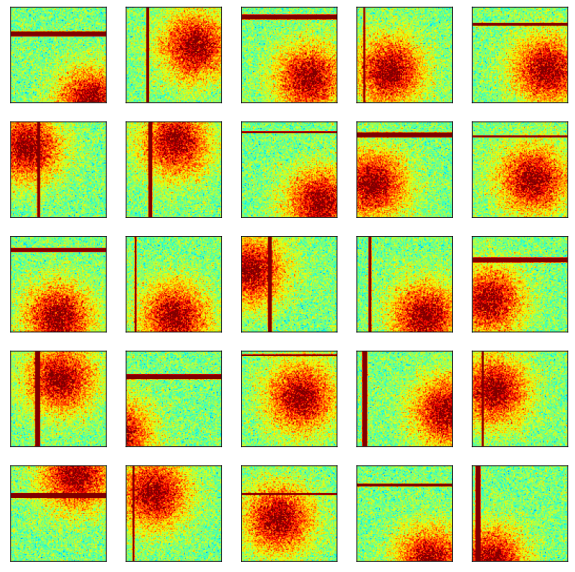

In [5]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nGauss)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [6]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,images,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1, 91, 91])


In [8]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

**Custom loss functions**

In [42]:
# L1 loss function
class L1loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,yHat,y):
        return tr.mean(tr.abs(yHat-y))
    
# L2 + Average loss function
class L2loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,yHat,y):
        return tr.mean((yHat-y)**2)+tr.abs(tr.mean(yHat))

# Cross-Correlatio loss function
class Corrloss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,yHat,y):
        return -(tr.sum((yHat-tr.mean(yHat))*(y-tr.mean(y))))*(1/((yHat.numel()-1)*tr.std(yHat)*tr.std(y)))
    
# Variance loss function (Additional Explorations)
class VarLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,yHat,y):
        return tr.var(yHat)

# Weighted L2 & Average loss (Additional Exploration)
class WeightedL2loss(nn.Module):
    def __init__(self,a=0.9,b=0.1):
        super().__init__()
        self.a=a
        self.b=b

    def forward(self,yHat,y):
        return self.a*tr.mean((yHat-y)**2)+self.b*tr.abs(tr.mean(yHat))

In [10]:
# Create the DL model
def createNet(lossfunction,lr=0.001):
    input_img_channels=1
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### ENCODER: 

            # conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.conv1=nn.Conv2d(input_img_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            ### DECODER:

            # trans-conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.t_conv1=nn.ConvTranspose2d(convOutChannels[1],convOutChannels[0],kernelSize,stride=poolSize)

            # trans-conv 2
            self.t_conv2=nn.ConvTranspose2d(convOutChannels[0],input_img_channels,kernelSize,stride=poolSize)



        def forward(self,x):
            ### Encoder

            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            pool1=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(pool1))  
            
            # Latent/code/bottleneck layer output
            latentAct=F.avg_pool2d(conv2act,poolSize)
            
            ### Decoder

            # first trans-conv-pool set
            tconv1act=F.relu(self.t_conv1(latentAct))

            # second trans-conv-pool set
            output=self.t_conv2(tconv1act)

            return output,conv1act,conv2act,latentAct,tconv1act

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=lossfunction()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [11]:
# test the model with one batch
net,lossfun,optimizer=createNet(lossfunction=L1loss)

X,y = next(iter(train_loader))
yHat,conv1act,conv2act,latentAct,tconv1act=net(X)

# check size of output
print('\nPredicted Category')
print(yHat.shape)
print('\nFeature maps after conv1')
print(conv1act.shape)
print('\nFeature maps after conv2')
print(conv2act.shape)

print('\nFeature Maps of latent layer')
print(latentAct.shape)
print('\nFeature maps after t-conv1')
print(tconv1act.shape)


# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)


Predicted Category
torch.Size([32, 1, 91, 91])

Feature maps after conv1
torch.Size([32, 6, 91, 91])

Feature maps after conv2
torch.Size([32, 4, 45, 45])

Feature Maps of latent layer
torch.Size([32, 4, 22, 22])

Feature maps after t-conv1
torch.Size([32, 6, 45, 45])
 
Loss: 
tensor(0.5774, grad_fn=<MeanBackward0>)


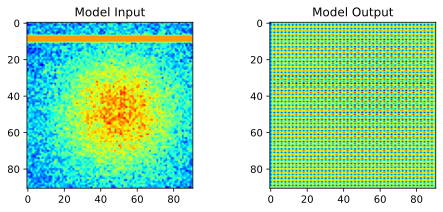

In [12]:
# lets see how they look
fig,ax=plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(tr.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model Input')
ax[1].imshow(tr.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model Output')
plt.show()

In [13]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
   ConvTranspose2d-3            [-1, 6, 45, 45]             222
   ConvTranspose2d-4            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Params size (MB): 0.00
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [14]:
# Create a function that trains the model

def trainModel(lossfunction,n_epochs=50):
    # create a new model
    net,lossfun,optimizer=createNet(lossfunction=lossfunction)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,testLoss,net

In [15]:
# Run the model and show the results
n_epochs=100
results={
    L1loss.__name__:{"result":None},
    L2loss.__name__:{"result":None},
    Corrloss.__name__:{"result":None},
}
loss_funs=[L1loss,L2loss,Corrloss]
for i,lossfn in enumerate(loss_funs):
    print(f'Loss function: {lossfn.__name__}')
    results[lossfn.__name__]["result"]=trainModel(lossfunction=lossfn,n_epochs=n_epochs)


Loss function: L1loss
1/100 complete!
2/100 complete!
3/100 complete!
4/100 complete!
5/100 complete!
6/100 complete!
7/100 complete!
8/100 complete!
9/100 complete!
10/100 complete!
11/100 complete!
12/100 complete!
13/100 complete!
14/100 complete!
15/100 complete!
16/100 complete!
17/100 complete!
18/100 complete!
19/100 complete!
20/100 complete!
21/100 complete!
22/100 complete!
23/100 complete!
24/100 complete!
25/100 complete!
26/100 complete!
27/100 complete!
28/100 complete!
29/100 complete!
30/100 complete!
31/100 complete!
32/100 complete!
33/100 complete!
34/100 complete!
35/100 complete!
36/100 complete!
37/100 complete!
38/100 complete!
39/100 complete!
40/100 complete!
41/100 complete!
42/100 complete!
43/100 complete!
44/100 complete!
45/100 complete!
46/100 complete!
47/100 complete!
48/100 complete!
49/100 complete!
50/100 complete!
51/100 complete!
52/100 complete!
53/100 complete!
54/100 complete!
55/100 complete!
56/100 complete!
57/100 complete!
58/100 complete!
5

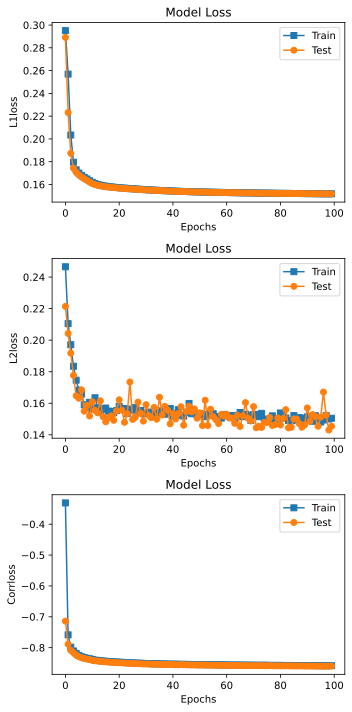

In [16]:
fig,ax=plt.subplots(3,1,figsize=(5,10))

for i,lossfn in enumerate(loss_funs):
    trainLoss,testLoss=results[lossfn.__name__]["result"][0:2]
    ax[i].plot(trainLoss,'s-',label="Train")
    ax[i].plot(testLoss,'o-',label="Test")
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(f'{lossfn.__name__}')
    ax[i].set_title('Model Loss')
    ax[i].legend()

plt.tight_layout()
plt.show()

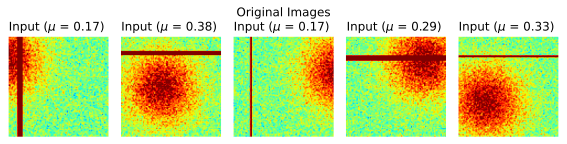

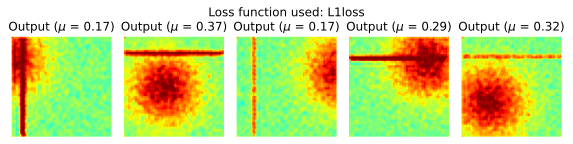

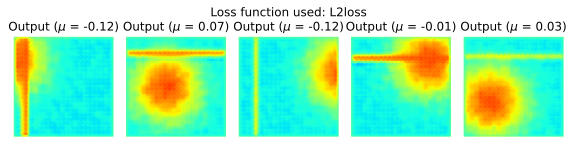

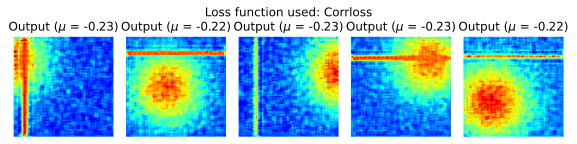

In [37]:
# visualize some images

X,y=next(iter(test_loader))

# plotting original images
fig,axs=plt.subplots(1,5,figsize=(8,2))
for i in range(5):
    G=tr.squeeze(y[i,0,:,:]).detach()
    axs[i].imshow(G,vmin=-1,vmax=1,cmap="jet")
    axs[i].axis('off')
    axs[i].set_title(f'Input ($\mu$ = {tr.mean(G):.2f}) ')
    plt.suptitle(f"Original Images")

plt.tight_layout()
for lossfn in loss_funs:
    yHat=results[lossfn.__name__]["result"][-1](X)[0]
    fig,axs=plt.subplots(1,5,figsize=(8,2))

    for i in range(5):
        O=tr.squeeze(yHat[i,0,:,:]).detach()
        if lossfn.__name__=="Corrloss":
            axs[i].imshow(O,vmin=tr.min(O),vmax=tr.max(O),cmap="jet")
        else:
            axs[i].imshow(O,vmin=-1,vmax=1,cmap="jet")
        axs[i].axis('off')
        axs[i].set_title(f'Output ($\mu$ = {tr.mean(O):.2f})')
    plt.suptitle(f"Loss function used: {lossfn.__name__}")
    plt.tight_layout()
plt.show()

**Additional Explorations**

In [ ]:
# 1) The code in this notebook requires "manually" switching between loss functions by (un)commenting. Modify the code so that you can list the name of the loss function as an input to makeTheNet().
# --> Already done

# 2) Here's an interesting loss function: minimize the variance of the model's output. Don't worry about comparing to the input image; just set the loss function to be the variance of the output. What do the results look like, and why does this happen?
# Its a total constant output, this is because we are minimizing variance

# 3) What if L2 minimization (MSE) is more important than average minimization? Modify the L2LossAve class so that the average has a weaker influence compared to the L2 loss.

# NOTE: This codeChallenge was designed to be a fun exercise to introduce you to the mechanics of creating and using custom-built loss functions. The PyTorch built-in MSELoss is actually the best one to use for autoencoders in most cases.

**Additional explorations (2: Variance Loss function)**

In [22]:
# Run the model and show the results
n_epochs=100
trainLoss,testLoss,net=trainModel(lossfunction=VarLoss,n_epochs=n_epochs)

1/100 complete!
2/100 complete!
3/100 complete!
4/100 complete!
5/100 complete!
6/100 complete!
7/100 complete!
8/100 complete!
9/100 complete!
10/100 complete!
11/100 complete!
12/100 complete!
13/100 complete!
14/100 complete!
15/100 complete!
16/100 complete!
17/100 complete!
18/100 complete!
19/100 complete!
20/100 complete!
21/100 complete!
22/100 complete!
23/100 complete!
24/100 complete!
25/100 complete!
26/100 complete!
27/100 complete!
28/100 complete!
29/100 complete!
30/100 complete!
31/100 complete!
32/100 complete!
33/100 complete!
34/100 complete!
35/100 complete!
36/100 complete!
37/100 complete!
38/100 complete!
39/100 complete!
40/100 complete!
41/100 complete!
42/100 complete!
43/100 complete!
44/100 complete!
45/100 complete!
46/100 complete!
47/100 complete!
48/100 complete!
49/100 complete!
50/100 complete!
51/100 complete!
52/100 complete!
53/100 complete!
54/100 complete!
55/100 complete!
56/100 complete!
57/100 complete!
58/100 complete!
59/100 complete!
60/100

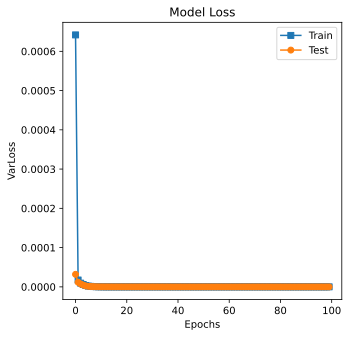

In [38]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(trainLoss,'s-',label="Train")
ax.plot(testLoss,'o-',label="Test")
ax.set_xlabel('Epochs')
ax.set_ylabel(f'{VarLoss.__name__}')
ax.set_title('Model Loss')
ax.legend()

plt.show()

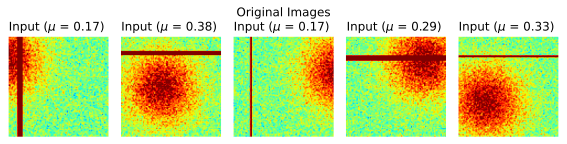

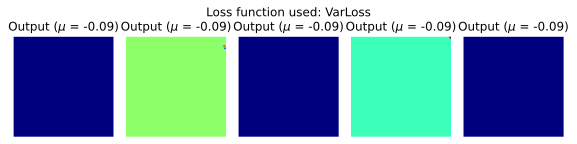

In [41]:
# visualize some images

X,y=next(iter(test_loader))

# plotting original images
fig,axs=plt.subplots(1,5,figsize=(8,2))
for i in range(5):
    G=tr.squeeze(y[i,0,:,:]).detach()
    axs[i].imshow(G,vmin=-1,vmax=1,cmap="jet")
    axs[i].axis('off')
    axs[i].set_title(f'Input ($\mu$ = {tr.mean(G):.2f}) ')
    plt.suptitle(f"Original Images")

plt.tight_layout()

yHat=net(X)[0]
fig,axs=plt.subplots(1,5,figsize=(8,2))

for i in range(5):
    O=tr.squeeze(yHat[i,0,:,:]).detach()
    axs[i].imshow(O,vmin=tr.min(O),vmax=tr.max(O),cmap="jet")
    axs[i].axis('off')
    axs[i].set_title(f'Output ($\mu$ = {tr.mean(O):.2f})')
plt.suptitle(f"Loss function used: {VarLoss.__name__}")

plt.tight_layout()
plt.show()

**Additional explorations (3: WeightedL2loss with L2 weight = 0.9 and avg weight =0.1)**

In [43]:
from functools import partial

# Run the model and show the results
n_epochs=100
trainLoss,testLoss,net=trainModel(lossfunction=partial(WeightedL2loss,0.9,0.1),n_epochs=n_epochs)

1/100 complete!
2/100 complete!
3/100 complete!
4/100 complete!
5/100 complete!
6/100 complete!
7/100 complete!
8/100 complete!
9/100 complete!
10/100 complete!
11/100 complete!
12/100 complete!
13/100 complete!
14/100 complete!
15/100 complete!
16/100 complete!
17/100 complete!
18/100 complete!
19/100 complete!
20/100 complete!
21/100 complete!
22/100 complete!
23/100 complete!
24/100 complete!
25/100 complete!
26/100 complete!
27/100 complete!
28/100 complete!
29/100 complete!
30/100 complete!
31/100 complete!
32/100 complete!
33/100 complete!
34/100 complete!
35/100 complete!
36/100 complete!
37/100 complete!
38/100 complete!
39/100 complete!
40/100 complete!
41/100 complete!
42/100 complete!
43/100 complete!
44/100 complete!
45/100 complete!
46/100 complete!
47/100 complete!
48/100 complete!
49/100 complete!
50/100 complete!
51/100 complete!
52/100 complete!
53/100 complete!
54/100 complete!
55/100 complete!
56/100 complete!
57/100 complete!
58/100 complete!
59/100 complete!
60/100

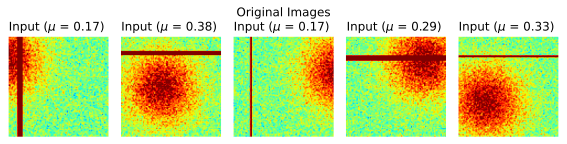

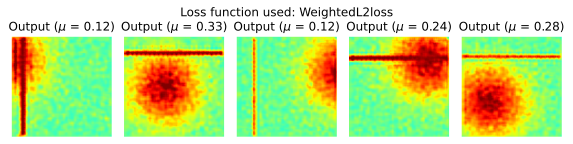

In [45]:
# visualize some images

X,y=next(iter(test_loader))

# plotting original images
fig,axs=plt.subplots(1,5,figsize=(8,2))
for i in range(5):
    G=tr.squeeze(y[i,0,:,:]).detach()
    axs[i].imshow(G,vmin=-1,vmax=1,cmap="jet")
    axs[i].axis('off')
    axs[i].set_title(f'Input ($\mu$ = {tr.mean(G):.2f}) ')
    plt.suptitle(f"Original Images")

plt.tight_layout()

yHat=net(X)[0]
fig,axs=plt.subplots(1,5,figsize=(8,2))

for i in range(5):
    O=tr.squeeze(yHat[i,0,:,:]).detach()
    axs[i].imshow(O,vmin=-1,vmax=1,cmap="jet")
    axs[i].axis('off')
    axs[i].set_title(f'Output ($\mu$ = {tr.mean(O):.2f})')
plt.suptitle(f"Loss function used: {WeightedL2loss.__name__}")

plt.tight_layout()
plt.show()